# Linear Regression

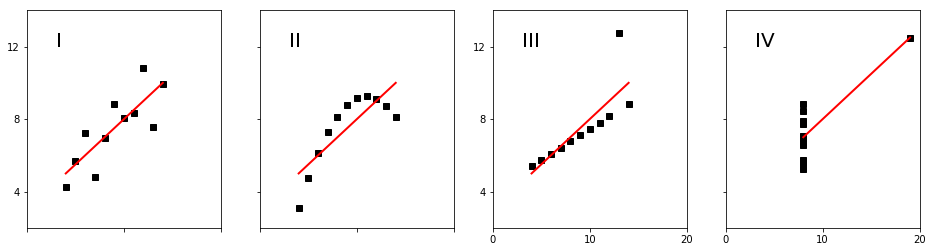

http://matplotlib.org/1.5.1/examples/pylab_examples/anscombe.html


In [1]:
# http://matplotlib.org/1.5.1/examples/pylab_examples/anscombe.html

from __future__ import print_function
"""
Edward Tufte uses this example from Anscombe to show 4 datasets of x
and y that have the same mean, standard deviation, and regression
line, but which are qualitatively different.
"""

import matplotlib.pyplot as plt
import numpy as np

x = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
y1 = np.array([8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68])
y2 = np.array([9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74])
y3 = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73])
x4 = np.array([8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8])
y4 = np.array([6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89])


def fit(x):
    return 3 + 0.5*x

plt.figure(figsize=(16,4))

xfit = np.array([np.amin(x), np.amax(x)])

plt.subplot(141)
plt.plot(x, y1, 'ks', xfit, fit(xfit), 'r-', lw=2)
plt.axis([2, 20, 2, 14])
plt.setp(plt.gca(), xticklabels=[], yticks=(4, 8, 12), xticks=(0, 10, 20))
plt.text(3, 12, 'I', fontsize=20)

plt.subplot(142)
plt.plot(x, y2, 'ks', xfit, fit(xfit), 'r-', lw=2)
plt.axis([2, 20, 2, 14])
plt.setp(plt.gca(), xticklabels=[], yticks=(4, 8, 12), yticklabels=[], xticks=(0, 10, 20))
plt.text(3, 12, 'II', fontsize=20)

plt.subplot(143)
plt.plot(x, y3, 'ks', xfit, fit(xfit), 'r-', lw=2)
plt.axis([2, 20, 2, 14])
plt.text(3, 12, 'III', fontsize=20)
plt.setp(plt.gca(), yticks=(4, 8, 12), xticks=(0, 10, 20))

plt.subplot(144)

xfit = np.array([np.amin(x4), np.amax(x4)])
plt.plot(x4, y4, 'ks', xfit, fit(xfit), 'r-', lw=2)
plt.axis([2, 20, 2, 14])
plt.setp(plt.gca(), yticklabels=[], yticks=(4, 8, 12), xticks=(0, 10, 20))
plt.text(3, 12, 'IV', fontsize=20)

# verify the stats
#pairs = (x, y1), (x, y2), (x, y3), (x4, y4)
#for x, y in pairs:
#    print('mean=%1.2f, std=%1.2f, r=%1.2f' % (np.mean(y), np.std(y), np.corrcoef(x, y)[0][1]))

plt.show()
print(r'http://matplotlib.org/1.5.1/examples/pylab_examples/anscombe.html')

The __regression__ problem is about finding a function $f(x; w)$ with parameters $w$, given example input vectors $x_i$ and corresponding outputs $y_i$ for $i=1,\dots, N$ such that

$$
y_i \approx f(x_i; w)
$$

This is done by minimizing a suitably defined function that measures the error

$$
E(w) = \sum_i D(y_i, f(x_i; w))
$$

A popular choice is 
$$
D(y, f) = \frac{1}{2}(y-f)^2
$$

The collection $\{x_i, y_i\}$ for $i=1\dots N$ is called a __data set__. 

If the mapping $f$ is linear __in $w$__, the problem is a __linear regression__ problem.

Note that the mapping $f$ itself does not need to be linear in $x$. It is the linearity in $w$ why we call the problem linear regression. 

## Definition: Linearity:
A function $g$ is linear when
$$
g(aw_1 + b w_2) = a g(w_1) + b g(w_2)
$$
for all scalar $a,b$ and vectors $w_1$ and $w_2$.

## Example1: Line Fitting

* We wish to fit a line to data where we are given pairs
$$
(y_i, x_i)
$$
for $i=1\dots N$ (or $i=0\dots N-1$)

* Model
$$
y_i \approx f(x; w_1, w_0) = w_0 + w_1 x 
$$


>  $x$ : Input 

>  $w_1$: The slope

>  $w_0$: Intercept

$f_i \equiv f(x_i; w_1, w_0)$

## Example2: Parabola Fitting

* We wish to fit a parabola to data where we are given pairs
$$
(y_i, x_i)
$$
for $i=1\dots N$ (or $i=0\dots N-1$)

* Model
$$
y_i \approx f(x; w_2, w_1, w_0) = w_0 + w_1 x + w_2 x^2
$$


>  $x$ : Input 

>  $w_2$: Quadratic term, sign 

>  $w_1$: Linear term

>  $w_0$: Constant

$f_i \equiv f(x_i; w_2, w_1, w_0)$

A parabola is not a linear function in $x$ but it is linear in the parameters $w_2, w_1, w_0$ 

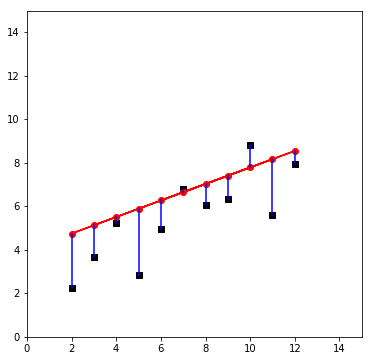

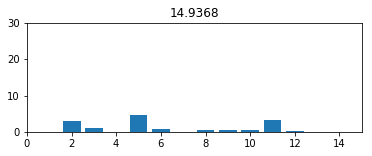

In [2]:
x = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])-2
y = np.array([8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68])-2
#y = np.array([9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74])-2
#y = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73])-2

def plot_fit(w1, w0):
    f = w0 + w1*x

    plt.figure(figsize=(6,6))
    plt.plot(x,y,'sk')
    plt.plot(x,f,'o-r')
    #plt.axis('equal')
    plt.xlim((0,15))
    plt.ylim((0,15))
    for i in range(len(x)):
        plt.plot((x[i],x[i]),(f[i],y[i]),'b')
    plt.show()
    plt.figure(figsize=(6,2))
    plt.bar(x,(f-y)**2/2)
    plt.title(np.sum((f-y)**2/2))
    plt.ylim((0,30))
    plt.xlim((0,15))
    plt.show()
    
plot_fit(0.38,3.99)

In [3]:
%matplotlib inline
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import matplotlib.pylab as plt
from IPython.display import clear_output, display, HTML


interact(plot_fit, w1=(-2, 2, 0.01), w0=(-5, 5, 0.01));

interactive(children=(FloatSlider(value=0.0, description='w1', max=2.0, min=-2.0, step=0.01), FloatSlider(value=0.0, description='w0', max=5.0, min=-5.0, step=0.01), Output()), _dom_classes=('widget-interact',))

### Example Dataset

Number of registered cars in Turkey, as a function of years.

|$i$|$y_i$|$x_i$|
|-------------|
|Index|Number of Cars (In Millions)|Year|


In [7]:
%matplotlib inline

import scipy as sc
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt

df_arac = pd.read_csv(u'data/arac.csv',sep=';')
df_arac[['Year','Car']]
#df_arac

,Year,Car
0,1966,91469
1,1967,112367
2,1968,125375
3,1969,137345
4,1970,137771
5,1971,153676
6,1972,187272
7,1973,240360
8,1974,313160
9,1975,403546


## Visualizing the data

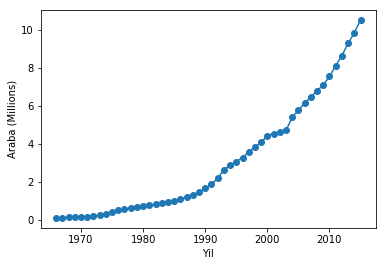

In [8]:
BaseYear = 1995
x = np.matrix(df_arac.Year[0:]).T-BaseYear
y = np.matrix(df_arac.Car[0:]).T/1000000.

plt.plot(x+BaseYear, y, 'o-')
plt.xlabel('Yil')
plt.ylabel('Araba (Millions)')

plt.show()

### Manual Model Fitting

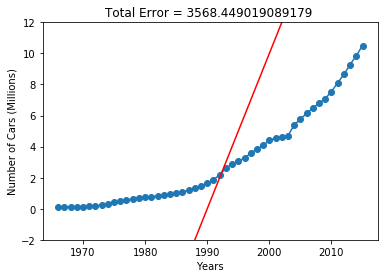

In [9]:
%matplotlib inline
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import matplotlib.pylab as plt
from IPython.display import clear_output, display, HTML


w_0 = 0.27150786
w_1 = 0.37332256

BaseYear = 1995
x = np.matrix(df_arac.Year[0:]).T-BaseYear
y = np.matrix(df_arac.Car[0:]).T/1000000.

fig, ax = plt.subplots()

f = w_1*x + w_0
plt.plot(x+BaseYear, y, 'o-')
ln, = plt.plot(x+BaseYear, f, 'r')


plt.xlabel('Years')
plt.ylabel('Number of Cars (Millions)')
ax.set_ylim((-2,12))
plt.close(fig)

def set_line(w_1, w_0):

    f = w_1*x + w_0
    e = y - f

    ln.set_ydata(f)
    ax.set_title('Total Error = {} '.format(np.asscalar(e.T*e/2)))
    display(fig)

set_line(1,5)

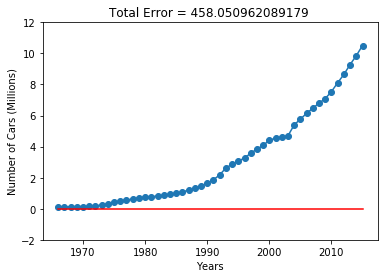

In [11]:
interact(set_line, w_1=(-2, 2, 0.01), w_0=(-5, 5, 0.01));

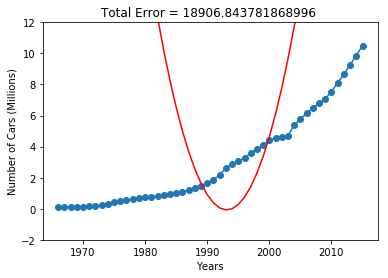

In [9]:
w_0 = 0.27150786
w_1 = 0.37332256
w_2 = 0.1

BaseYear = 1995
x = np.array(df_arac.Year[0:]).T-BaseYear
y = np.array(df_arac.Car[0:]).T/1000000.

fig, ax = plt.subplots()

f = w_2*x**2 + w_1*x + w_0
plt.plot(x+BaseYear, y, 'o-')
ln, = plt.plot(x+BaseYear, f, 'r')


plt.xlabel('Years')
plt.ylabel('Number of Cars (Millions)')
ax.set_ylim((-2,12))
plt.close(fig)

def set_line(w_2, w_1, w_0):
    f = w_2*x**2 + w_1*x + w_0
    e = y - f
    ln.set_ydata(f)
    ax.set_title('Total Error = {} '.format(np.sum(e*e/2)))
    display(fig)

set_line(w_2, w_1, w_0)

In [10]:
interact(set_line, w_2=(-0.1,0.1,0.001), w_1=(-2, 2, 0.01), w_0=(-5, 5, 0.01))

interactive(children=(FloatSlider(value=0.0, description='w_2', max=0.1, min=-0.1, step=0.001), FloatSlider(value=0.0, description='w_1', max=2.0, min=-2.0, step=0.01), FloatSlider(value=0.0, description='w_0', max=5.0, min=-5.0, step=0.01), Output()), _dom_classes=('widget-interact',))

<function __main__.set_line>

## Example

* Fitting the model: estimating $w = [w_0, w_1]$

* As there is noise, we can't hope to fit our model exactly

* Define the error for each observation 

$$e_i = \frac{1}{2}(y_i - f(x_i; w))^2$$

squared Euclidian norm. The constant $1/2$ is useful for a cosmetical simplification.

* Total Error (sum over all data points)

$$
E(w) = \frac{1}{2} \sum_i (y_i - f(x_i; w))^2
$$

* We can minimize the total error by adjusting $w_0$ and $w_1$

### Visualization of the error surface

A good approach for low dimensional problems is the visualization of the error surface. We evaluate her exhaustively the error for each possible  setting of the parameter $w$. 

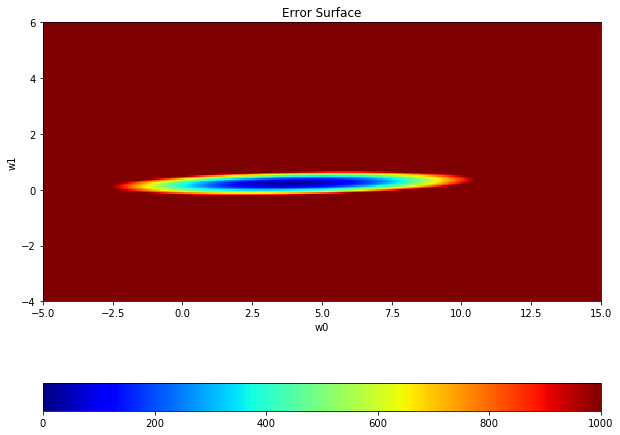

In [15]:
from itertools import product

BaseYear = 1995
x = np.matrix(df_arac.Year[0:]).T-BaseYear
y = np.matrix(df_arac.Car[0:]).T/1000000.

# Setup the vandermonde matrix
N = len(x)
A = np.hstack((np.ones((N,1)), x))

left = -5
right = 15
bottom = -4
top = 6
step = 0.05
W0 = np.arange(left,right, step)
W1 = np.arange(bottom,top, step)

ErrSurf = np.zeros((len(W1),len(W0)))

for i,j in product(range(len(W1)), range(len(W0))):
    e = y - A*np.matrix([W0[j], W1[i]]).T
    ErrSurf[i,j] = e.T*e/2

plt.figure(figsize=(10,10))
plt.imshow(ErrSurf, interpolation='nearest', 
           vmin=0, vmax=1000,origin='lower',
           extent=(left,right,bottom,top),cmap='jet')
plt.xlabel('w0')
plt.ylabel('w1')
plt.title('Error Surface')
plt.colorbar(orientation='horizontal')
plt.show()


# How to fit the model automatically?

## Idea: Least Squares

* Compute the derivative of the total error w.r.t. $w_0$ and $w_1$ and solve the equations
* Derivation in Vector Notation

\begin{eqnarray}
\left(
\begin{array}{c}
y_0 \\ y_1 \\ \vdots \\ y_{N-1} 
\end{array}
\right)
\approx
\left(
\begin{array}{cc}
1 & x_0 \\ 1 & x_1 \\ \vdots \\ 1 & x_{N-1}  
\end{array}
\right) 
\left(
\begin{array}{c}
 w_0 \\ w_1  
\end{array}
\right)
\end{eqnarray}

\begin{eqnarray}
y \approx A w
\end{eqnarray}

> $A = A(x)$: Design Matrix

> $w$: Model Parameters

> $y$: Observations

* Error vector: $$e = y - Aw$$

\begin{eqnarray}
E(w) & = & \frac{1}{2}e^\top e = \frac{1}{2}(y - Aw)^\top (y - Aw)\\
& = & \frac{1}{2}y^\top y - \frac{1}{2} y^\top Aw - \frac{1}{2} w^\top A^\top y + \frac{1}{2} w^\top A^\top Aw \\
& = & \frac{1}{2} y^\top y - y^\top Aw + \frac{1}{2} w^\top A^\top Aw \\
\end{eqnarray}

### Gradient
Derivative of the function $E$ with respect to a vector 
\begin{eqnarray}
\frac{d E}{d w } & = & \left(\begin{array}{c}
 \partial E/\partial w_0 \\ \partial E/\partial w_1 \\ \vdots \\  \partial E/\partial w_{K-1}
\end{array}\right)
\end{eqnarray}
  
We derive the gradient of the total error as
\begin{eqnarray}
\frac{d}{d w }E(w) & = & \frac{d}{d w }(\frac{1}{2} y^\top y) &+ \frac{d}{d w }(- y^\top Aw) &+ \frac{d}{d w }(\frac{1}{2} w^\top A^\top Aw) \\
& = & 0 &- A^\top y &+ A^\top A w \\
& = & - A^\top (y - Aw) \\
& = & - A^\top e \\
& \equiv & \nabla E(w)
\end{eqnarray}

#### Two basic results that everyone should know
* Gradient of an inner product
\begin{eqnarray}
\frac{d}{d w }(h^\top w) & = & h
\end{eqnarray}

* Gradient of a Quadratic form
\begin{eqnarray}
\frac{d}{d w }(w^\top K w) & = & (K+K^\top) w
\end{eqnarray}


### Least Squares solution: Directly solving the equations 
* Find

\begin{eqnarray}
w^* & = & \arg\min_{w} E(w)
\end{eqnarray}

* Optimality Condition (from basic Calculus, the gradient should vanish)

\begin{eqnarray}
\nabla E(w^*) & = & 0
\end{eqnarray}


* Set the derivative to zero and solve for $w^*$

\begin{eqnarray}
0 & = & - A^\top y + A^\top A w^*  \\
A^\top y & = &  A^\top A w^* \\
w^* & = & (A^\top A)^{-1} A^\top y 
\end{eqnarray}

* Projection interpretation:

\begin{eqnarray}
f & = A w^*  = A (A^\top A)^{-1} A^\top y 
\end{eqnarray}

$P$ is the orthogonal projection matrix onto the space spanned by the columns of $A$
\begin{eqnarray}
P & = & A (A^\top A)^{-1} A^\top 
\end{eqnarray}

To understand the last equation, consider the case when $A = a$ is a column vector. The projector is
\begin{eqnarray}
P & = & \frac{a}{\|a\|} \frac{a^\top}{\|a\|} 
\end{eqnarray}
Hence the approximation is given by 
\begin{eqnarray}
f & = a w^*  = \frac{a}{\|a\|} \left( \frac{a^\top}{\|a\|} y \right)
\end{eqnarray}

This expression shows that the vector $y$ is projected onto the unit vector pointing in the direction of $A$.

Parameters: 
w0 =  [[ 3.94060309]] 
w1 =  [[ 0.194523]]
Error: [[ 26.15676891]]


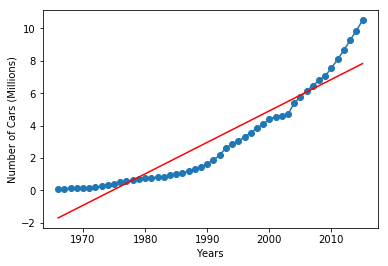

In [16]:
# Solving the Normal Equations

# Setup the Design matrix
N = len(x)
A = np.hstack((np.ones((N,1)), x))

#plt.imshow(A, interpolation='nearest')
# Solve the least squares problem
w_ls,E,rank,sigma = np.linalg.lstsq(A, y)

print('Parameters: \nw0 = ', w_ls[0],'\nw1 = ', w_ls[1] )
print('Error:', E/2)

f = np.asscalar(w_ls[1])*x + np.asscalar(w_ls[0])
plt.plot(x+BaseYear, y, 'o-')
plt.plot(x+BaseYear, f, 'r')


plt.xlabel('Years')
plt.ylabel('Number of Cars (Millions)')
plt.show()

In [17]:
#f = A*w_ls

f = A*w_star
plt.plot(x+BaseYear, y, 'o-')
plt.plot(x+BaseYear, f, 'r')

plt.xlabel('Years')
plt.ylabel('Number of Cars')

plt.show()

e = y - f

print('Total Error = ', np.asscalar(e.T*e/2))

NameError: name 'w_star' is not defined

## Fitting a polynomial 

Often, fitting a line between inputs and outputs is not enough. A good candidate is fitting a higher order polynomial. 

### Parabola
\begin{eqnarray}
\left(
\begin{array}{c}
y_0 \\ y_1 \\ \vdots \\ y_{N-1} 
\end{array}
\right)
\approx
\left(
\begin{array}{ccc}
1 & x_0 & x_0^2 \\ 1 & x_1 & x_1^2 \\ \vdots \\ 1 & x_{N-1} & x_{N-1}^2   
\end{array}
\right) 
\left(
\begin{array}{c}
 w_0 \\ w_1  \\ w_2
\end{array}
\right)
\end{eqnarray}

### Polynomial of order $K$
\begin{eqnarray}
\left(
\begin{array}{c}
y_0 \\ y_1 \\ \vdots \\ y_{N-1} 
\end{array}
\right)
\approx
\left(
\begin{array}{ccccc}
1 & x_0 & x_0^2 & \dots & x_0^K \\ 1 & x_1 & x_1^2 & \dots & x_1^K\\ \vdots \\ 1 & x_{N-1} & x_{N-1}^2 & \dots & x_{N-1}^K  
\end{array}
\right) 
\left(
\begin{array}{c}
 w_0 \\ w_1  \\ w_2 \\ \vdots \\ w_K
\end{array}
\right)
\end{eqnarray}

The model is identical

\begin{eqnarray}
y \approx A w
\end{eqnarray}

> $A = A(x)$: Design Matrix

> $w$: Model Parameters

> $y$: Observations

Design matrices for polynomial fitting are also known as __Vandermonde__ matrices.

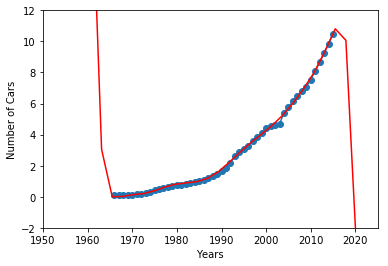

In [21]:
# Setup the vandermonde matrix
N = len(x)
degree = 11
#A = np.hstack((np.power(x,0), np.power(x,1), np.power(x,2)))
A = np.hstack((np.power(x,i) for i in range(degree+1)))
xx = np.matrix(np.linspace(np.asscalar(x[0])-10,np.asscalar(x[-1])+10,30)).T
A2 = np.hstack((np.power(xx,i) for i in range(degree+1)))

#plt.imshow(A, interpolation='nearest')
# Solve the least squares problem
w_ls,E,rank,sigma = np.linalg.lstsq(A, y)

f = A2*w_ls
plt.plot(x+BaseYear, y, 'o-')
plt.plot(xx+BaseYear, f, 'r')

plt.xlabel('Years')
plt.ylabel('Number of Cars')

plt.gca().set_ylim((-2,12))
plt.gca().set_xlim((1950,2025))

plt.show()


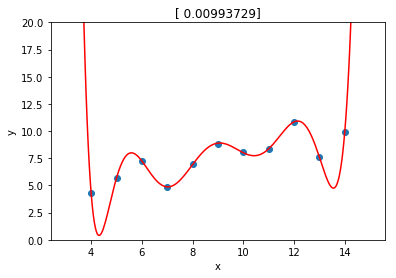

In [23]:
x = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
N = len(x)
x = x.reshape((N,1))
y = np.array([8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]).reshape((N,1))
#y = np.array([9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74]).reshape((N,1))
#y = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]).reshape((N,1))

def fit_and_plot_poly(degree):

    #A = np.hstack((np.power(x,0), np.power(x,1), np.power(x,2)))
    A = np.hstack((np.power(x,i) for i in range(degree+1)))
    # Setup the vandermonde matrix
    xx = np.matrix(np.linspace(np.asscalar(min(x))-1,np.asscalar(max(x))+1,300)).T
    A2 = np.hstack((np.power(xx,i) for i in range(degree+1)))

    #plt.imshow(A, interpolation='nearest')
    # Solve the least squares problem
    w_ls,E,rank,sigma = np.linalg.lstsq(A, y)
    f = A2*w_ls
    plt.plot(x, y, 'o')
    plt.plot(xx, f, 'r')

    plt.xlabel('x')
    plt.ylabel('y')

    plt.gca().set_ylim((0,20))
    #plt.gca().set_xlim((1950,2025))
    plt.title(E)
    plt.show()

fit_and_plot_poly(9)

In [24]:
interact(fit_and_plot_poly, degree=(0,12))

interactive(children=(IntSlider(value=6, description='degree', max=12), Output()), _dom_classes=('widget-interact',))

<function __main__.fit_and_plot_poly>

# Beyond polynomial fitting

We can fit other functions than polynomials. For example, if data are known to be near periodic with period $T$, one possibility is fitting a sinusoidal as:

\begin{eqnarray}
y_k & = & a_0 \cos(2\pi x_k /T ) + b_0 \sin(2\pi x_k /T ) 
\end{eqnarray}

Then the Vandermonde matrix will have the entries

\begin{eqnarray}
\left(
\begin{array}{c}
y_0 \\ y_1 \\ \vdots \\ y_{N-1} 
\end{array}
\right)
\approx
\left(
\begin{array}{ccc}
1 & x_0 & x_0^2 \\ 1 & \cos(\omega x_1) & \sin(x_1^2 \\ \vdots \\ 1 & x_{N-1} & x_{N-1}^2   
\end{array}
\right) 
\left(
\begin{array}{c}
 w_0 \\ w_1  \\ w_2
\end{array}
\right)
\end{eqnarray}


## Basis Regression




## Autoregressive (AR) Models 

Idea: Use past values of a time series as inputs. 
\begin{eqnarray}
y_k & = & w_1 y_{k-1} + w_2 y_{k-2} + w_3 y_{k-3} + \dots + w_L y_{k-L} + \epsilon_k
\end{eqnarray}

The design matrix consists of past values of the process. Such a design matrix is also known as a Toeplitz matrix.
\begin{eqnarray}
\left(
\begin{array}{c}
y_L \\
\vdots \\
y_k \\ y_{k+1} \\ \vdots \\ y_{N} 
\end{array}
\right)
\approx
\left(
\begin{array}{ccccc}
y_{L-1} & y_{L-2} & y_{L-3} & \dots & y_{0}\\
\vdots \\
y_{k-1} & y_{k-2} & y_{k-3} & \dots & y_{k-L} \\ y_{k} & y_{k-1} & y_{k-2} & \dots & y_{k-L+1} \\ \vdots \\ 
y_{N-1} & y_{N-2} & y_{N-3} & \dots & y_{N-L}  
\end{array}
\right) 
\left(
\begin{array}{c}
 w_1  \\ w_2 \\ w_3 \\ \vdots \\ w_L
\end{array}
\right)
\end{eqnarray}


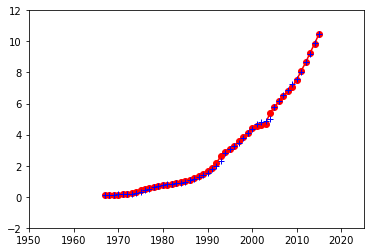

In [25]:
import scipy as sc
import scipy.linalg as la

# Order
L = 1

BaseYear = 1995
x = np.matrix(df_arac.Year[0:]).T-BaseYear
y = np.matrix(df_arac.Car[0:]).T/1000000.


def AR_model(y,L):
    N = len(y) - L
    A = np.hstack((np.matrix(y[L-i:L-i+N]) for i in range(1,L+1) ))
    yy = np.matrix(y[L:(L+N+1)])
    return A, yy
   
def make_AR_model(y, L):
    B = la.toeplitz(y[:-1], y[0:L])
    AA = B[L-1:,:]
    yy = y[L:]
    return AA, yy

A,yy = AR_model(y, L)
#plt.imshow(A, interpolation='nearest')
# Solve the least squares problem
w_ls,E,rank,sigma = np.linalg.lstsq(A, yy)

f = A*w_ls

#plt.figure(figsize=(14,8))
plt.plot(x[L:]+BaseYear, yy, 'o-r')
plt.plot(x[L:]+BaseYear, f, '+b')

plt.gca().set_ylim((-2,12))
plt.gca().set_xlim((1950,2025))

plt.show()

In [26]:
y = np.mat([1,2,3,4,5,6,7]).T

L = 2
A, yy = AR_model(y,L)
print('Order',L)
print(A)
print(yy)



Order 2
[[2 1]
 [3 2]
 [4 3]
 [5 4]
 [6 5]]
[[3]
 [4]
 [5]
 [6]
 [7]]


[[ 2.   ]
 [ 2.08 ]
 [-0.096]
 [ 0.016]]


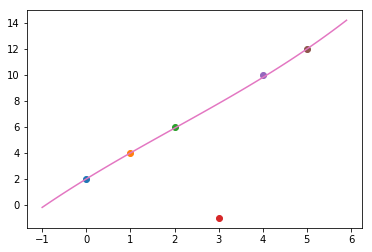

In [1]:
%matplotlib inline
#from cvxpy import *
import cvxpy as cvx
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt

np.set_printoptions(precision=3)

x = np.matrix('[0,1,2,3,4,5]').T
xx = np.matrix(np.arange(-1,6,0.1)).T
y = np.matrix('[2,4,6,-1,10,12]').T
N = len(x)
degree = 3
#A = np.hstack((np.power(x,0), np.power(x,1), np.power(x,2)))
A = np.hstack((np.power(x,i) for i in range(degree+1)))
A2 = np.hstack((np.power(xx,i) for i in range(degree+1)))


# Construct the problem.
w = cvx.Variable(degree+1)
objective = cvx.Minimize(cvx.norm(A*w - y, 1.1))
#constraints = [0 <= x, x <= 10]
#prob = Problem(objective, constraints)
prob = cvx.Problem(objective)

# The optimal objective is returned by prob.solve().
result = prob.solve()
# The optimal value for x is stored in x.value.
print(w.value)
# The optimal Lagrange multiplier for a constraint
# is stored in constraint.dual_value.
#print(constraints[0].dual_value)

plt.plot(x.T.tolist(), y.T.tolist(), 'o')
plt.plot(xx, A2*w.value, '-')
plt.show()